# Deep Neural Networks

In this Notebook we predict the hourly demand of taxi trips in Chicago. We build models varying in complexity (3 levels), choosing the best one for further performance optimization methods (e.g. hyperparmater tuning, dropoff value, ...).

Our cleaned data that we used for predictions can be found on sciebo: INSERT LINK

The notebook is structured as follows:
1. Feature Selection
2. DNN Architectures

    2.1 Simple NN

    2.2 DNN: 4 hidden layers

    2.3 DNN: 8 hidden layers

3. Optimizing DNN
4. Prediction: low resolution h3 hexagons
5. Prediction: medium resolution h3 hexagons
6. Prediction: high resolution h3 hexagons

In [1]:
import pandas as pd
import numpy as np
import h3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, max_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

In [2]:
chicago = pd.read_csv("Chicago_Trips_Weather_2024.csv")

# 1 Feature Selection

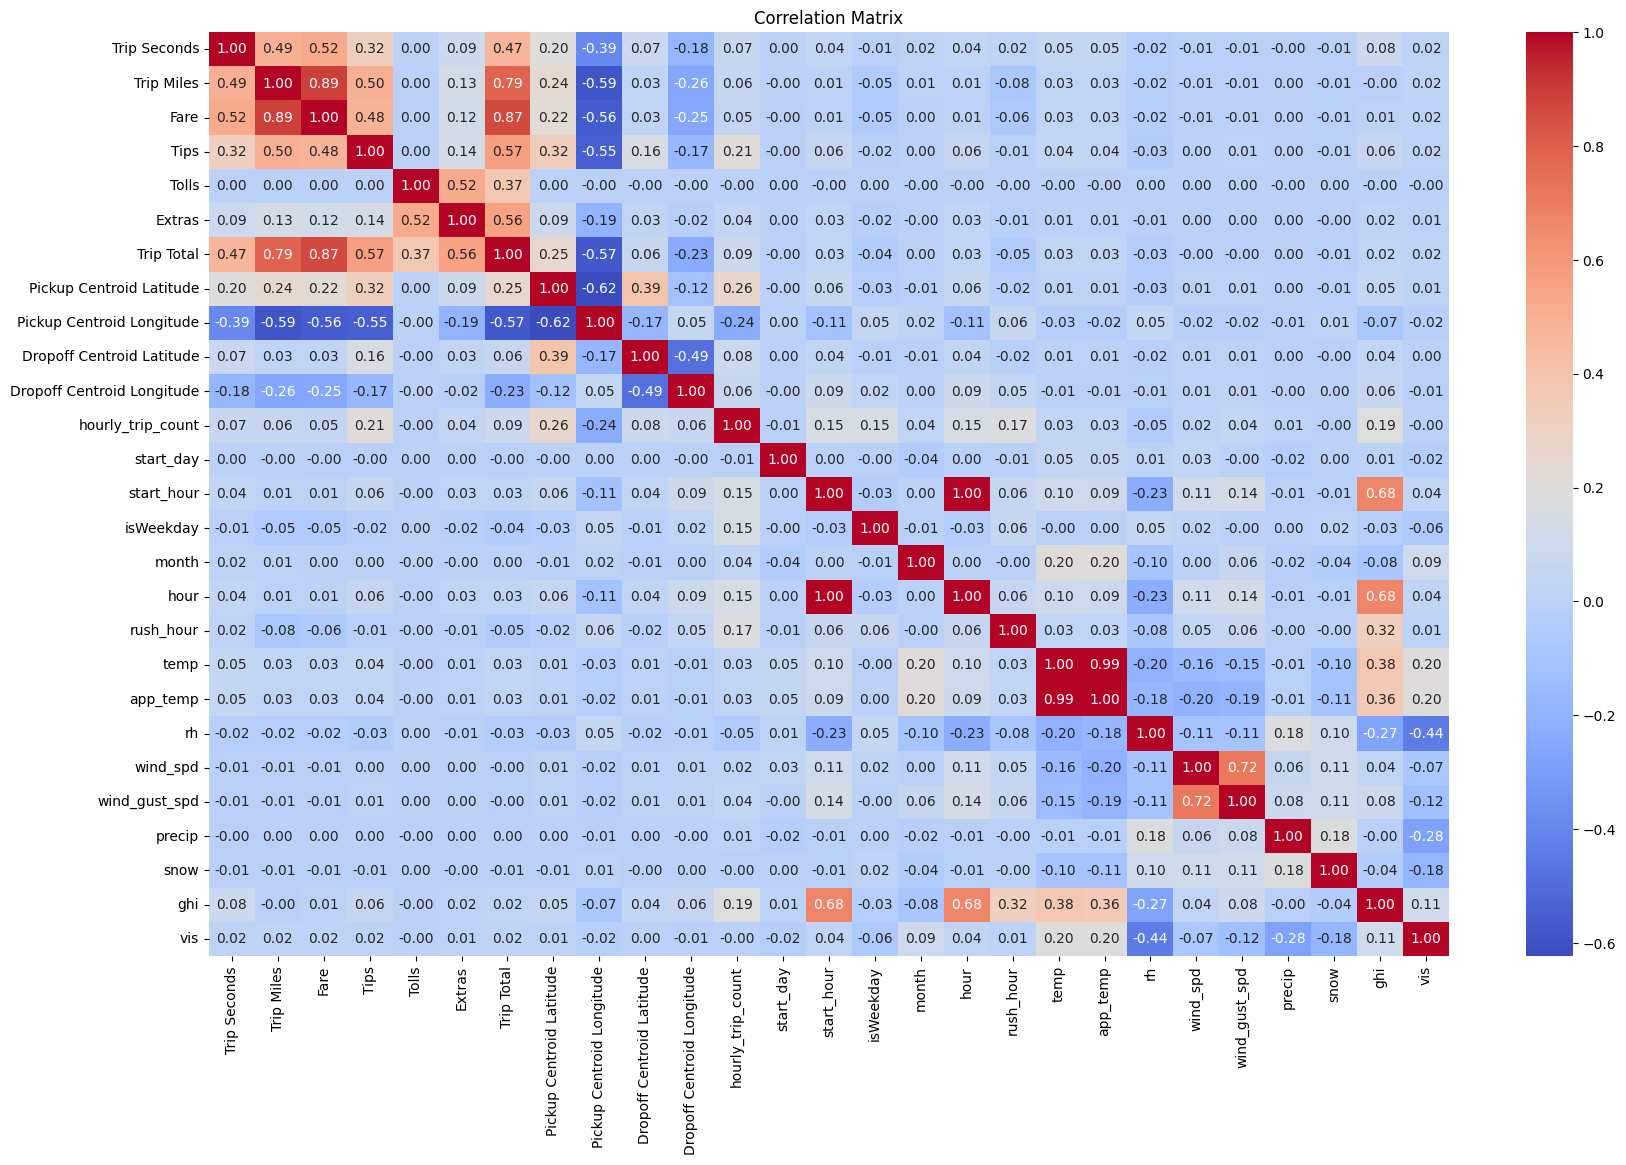

In [3]:
# correlation matrix
numeric_columns = chicago.select_dtypes(include='number')

corr_matrix = numeric_columns.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


We can see that the temperature (temp) and the felt temperature (app_temp) are highly correlated, very close to 1 so we should keep only one of them. We decided to keep the actual temperature instead of the felt temperature.

Also the Trip Total and all other more detailed cost information (fare, tips, tolls, extras) are highly corelated. Therefore we decided to drop the detailed information and keep the trip total to further simplify our data structure for the prediction models.

Further we drop redundant information such as start_hour (same as hour), Trip Start/End Timestamp, Trip Start Hour.

We also remove exclude the location data in form of centroid longitute and latitute since we will be using the hexagons instead of coordinates.

In [4]:
chicago.drop(columns=["app_temp", "Fare", "Tips", "Tolls", "Extras", "start_hour", "Trip Start Timestamp", "Trip End Timestamp",
                      "Pickup Centroid Latitude", "Pickup Centroid Longitude", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude",
                      "Trip Start Hour", "timestamp_utc", "trip_start_time_bucket", "dropoff_h3"], inplace=True)

In [5]:
chicago.columns

Index(['Trip Seconds', 'Trip Miles', 'Trip Total', 'pickup_h3',
       'hourly_trip_count', 'start_day', 'isWeekday', 'month', 'hour',
       'rush_hour', 'season', 'temp', 'rh', 'wind_spd', 'wind_gust_spd',
       'precip', 'snow', 'ghi', 'vis'],
      dtype='object')

In [6]:
chicago.head()

,Trip Seconds,Trip Miles,Trip Total,pickup_h3,hourly_trip_count,start_day,isWeekday,month,hour,rush_hour,season,temp,rh,wind_spd,wind_gust_spd,precip,snow,ghi,vis
0,4051.0,17.12,60.00,88275934edfffff,104,19,1,1,17,1,winter,-10.7,68.0,6.70,12.8,0.0,0.0,426.0,10.0
1,517.0,3.39,14.69,882664c163fffff,18,5,1,1,9,1,winter,-0.9,69.0,2.60,3.5,0.0,0.0,0.0,16.0
2,1004.0,1.18,19.66,882664c1a9fffff,128,18,1,1,19,1,winter,-4.6,65.0,3.60,3.6,0.0,0.0,424.0,16.0
3,484.0,1.59,9.49,882664c1adfffff,83,4,1,1,7,1,winter,1.4,71.0,4.09,7.5,0.0,0.0,0.0,16.0
4,1686.0,13.01,47.70,882664c1e3fffff,63,25,1,1,11,0,winter,1.8,96.0,3.60,4.6,0.0,0.0,0.0,10.0


# 2. DNN Architectures

## 2.2 Simple NN

Before we can use the data with the simple nn, we have to preprocess some data: 
1. encode the seasons (they are still strings)
2. label the hexagons

In [7]:
# 1. encode seasons
season_map = {
    'spring': 0,
    'summer': 1,
    'autumn': 2,
    'winter': 3
}

chicago['season_encoded'] = chicago['season'].map(season_map)
chicago.drop(columns=["season"], inplace=True)
chicago.rename(columns={"season_encoded": "season"}, inplace=True)

In [8]:
chicago.head()

,Trip Seconds,Trip Miles,Trip Total,pickup_h3,hourly_trip_count,start_day,isWeekday,month,hour,rush_hour,temp,rh,wind_spd,wind_gust_spd,precip,snow,ghi,vis,season
0,4051.0,17.12,60.00,88275934edfffff,104,19,1,1,17,1,-10.7,68.0,6.70,12.8,0.0,0.0,426.0,10.0,3
1,517.0,3.39,14.69,882664c163fffff,18,5,1,1,9,1,-0.9,69.0,2.60,3.5,0.0,0.0,0.0,16.0,3
2,1004.0,1.18,19.66,882664c1a9fffff,128,18,1,1,19,1,-4.6,65.0,3.60,3.6,0.0,0.0,424.0,16.0,3
3,484.0,1.59,9.49,882664c1adfffff,83,4,1,1,7,1,1.4,71.0,4.09,7.5,0.0,0.0,0.0,16.0,3
4,1686.0,13.01,47.70,882664c1e3fffff,63,25,1,1,11,0,1.8,96.0,3.60,4.6,0.0,0.0,0.0,10.0,3


In [9]:
# Data preparation

# Numeric features to use
numeric_cols = [
    'Trip Seconds', 'Trip Miles', 'Trip Total', 'start_day', 'hour', 'month', 'rush_hour', 'isWeekday',
    'temp', 'rh', 'wind_spd', 'precip', 'snow', 'ghi', 'vis', 'season'
]

target_col = 'hourly_trip_count'
h3_col = 'pickup_h3'

# -------------------------------
# 2. Encode H3 hex IDs as integers
# -------------------------------

unique_hexes = chicago[h3_col].unique()
hex_id_to_index = {h: i for i, h in enumerate(unique_hexes)}
chicago['pickup_h3_idx'] = chicago[h3_col].map(hex_id_to_index)
num_hexes = len(hex_id_to_index)

# -------------------------------
# 3. Normalize numeric features
# -------------------------------

scaler = StandardScaler()
X_numeric = scaler.fit_transform(chicago[numeric_cols])
X_h3 = chicago['pickup_h3_idx'].values
y = chicago[target_col].values

# -------------------------------
# 4. Train/test split
# -------------------------------

Xn_train, Xn_val, h3_train, h3_val, y_train, y_val = train_test_split(
    X_numeric, X_h3, y, test_size=0.2, random_state=42
)

# Convert to tensors
Xn_train_tensor = torch.tensor(Xn_train, dtype=torch.float32)
Xn_val_tensor = torch.tensor(Xn_val, dtype=torch.float32)
Xh_train_tensor = torch.tensor(h3_train, dtype=torch.long)
Xh_val_tensor = torch.tensor(h3_val, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# -------------------------------
# 5. Create DataLoaders
# -------------------------------

train_ds = TensorDataset(Xn_train_tensor, Xh_train_tensor, y_train_tensor)
val_ds = TensorDataset(Xn_val_tensor, Xh_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [10]:
# -------------------------------
# 6. Define different models
# -------------------------------

# Define a model base to allow all models to share the same embedded layer
class BaseH3NN(nn.Module):
    def __init__(self, input_dim, num_hexes, h3_embed_dim):
        super().__init__()
        self.h3_embedding = nn.Embedding(num_hexes, h3_embed_dim)
        self.input_dim = input_dim + h3_embed_dim


class SimpleNN(BaseH3NN):
    def __init__(self, input_dim, num_hexes, h3_embed_dim=8):
        super().__init__(input_dim, num_hexes, h3_embed_dim)
        self.fc1 = nn.Linear(self.input_dim, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x_num, x_h3):
        x = torch.cat([x_num, self.h3_embedding(x_h3)], dim=1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class DeepNN_4Layers(BaseH3NN):
    def __init__(self, input_dim, num_hexes, h3_embed_dim=8):
        super().__init__(input_dim, num_hexes, h3_embed_dim)
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x_num, x_h3):
        x = torch.cat([x_num, self.h3_embedding(x_h3)], dim=1)
        return self.net(x)

class DeepNN_8Layers(BaseH3NN):
    def __init__(self, input_dim, num_hexes, h3_embed_dim=8):
        super().__init__(input_dim, num_hexes, h3_embed_dim)
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 96),
            nn.ReLU(),
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 1)
        )

    def forward(self, x_num, x_h3):
        x = torch.cat([x_num, self.h3_embedding(x_h3)], dim=1)
        return self.net(x)

simple_nn = SimpleNN(input_dim=Xn_train.shape[1], num_hexes=num_hexes)
dnn_4l = DeepNN_4Layers(input_dim=Xn_train.shape[1], num_hexes=num_hexes)
dnn_8l = DeepNN_8Layers(input_dim=Xn_train.shape[1], num_hexes=num_hexes)

optimizer_simple_nn = torch.optim.Adam(simple_nn.parameters(), lr=0.001)
optimizer_dnn_4l = torch.optim.Adam(dnn_4l.parameters(), lr=0.001)
optimizer_dnn_8l = torch.optim.Adam(dnn_8l.parameters(), lr=0.001)

loss_fn = nn.MSELoss()

### Training: Simple NN

In [ ]:
# Training the simple nn
num_epochs = 50


for epoch in range(num_epochs):
    simple_nn.train()
    total_loss = 0
    for xb, hb, yb in train_loader:
        optimizer_simple_nn.zero_grad()
        preds = simple_nn(xb, hb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer_simple_nn.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

Epoch 1, Train Loss: 1126.6424
Epoch 2, Train Loss: 852.1041
Epoch 3, Train Loss: 827.2991
Epoch 4, Train Loss: 819.8814
Epoch 5, Train Loss: 815.3503
Epoch 6, Train Loss: 814.0331
Epoch 7, Train Loss: 812.4884
Epoch 8, Train Loss: 811.3087
Epoch 9, Train Loss: 811.3824
Epoch 10, Train Loss: 810.1949
Epoch 11, Train Loss: 808.0846
Epoch 12, Train Loss: 802.2317
Epoch 13, Train Loss: 797.8586
Epoch 14, Train Loss: 795.4436
Epoch 15, Train Loss: 794.5738
Epoch 16, Train Loss: 794.0348
Epoch 17, Train Loss: 791.7907
Epoch 18, Train Loss: 791.7479
Epoch 19, Train Loss: 791.2680
Epoch 20, Train Loss: 791.2013
Epoch 21, Train Loss: 791.3885
Epoch 22, Train Loss: 790.0506
Epoch 23, Train Loss: 791.2020
Epoch 24, Train Loss: 789.4384
Epoch 25, Train Loss: 789.7345
Epoch 26, Train Loss: 790.3971
Epoch 27, Train Loss: 790.4639
Epoch 28, Train Loss: 788.9318
Epoch 29, Train Loss: 789.5756
Epoch 30, Train Loss: 789.8990
Epoch 31, Train Loss: 789.2853
Epoch 32, Train Loss: 789.9297


In [ ]:
# Evaluation on validation set
simple_nn.eval()
with torch.no_grad():
    val_preds = simple_nn(Xn_val_tensor, Xh_val_tensor)
    val_loss = loss_fn(val_preds, y_val_tensor)
    print(f"Validation MSE: {val_loss.item():.4f}")

### Training: DNN 4 layers

In [ ]:
# Training the dnn 4 layers
for epoch in range(num_epochs):
    dnn_4l.train()
    total_loss = 0
    for xb, hb, yb in train_loader:
        optimizer_dnn_4l.zero_grad()
        preds = dnn_4l(xb, hb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer_dnn_4l.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

In [ ]:
# Evaluation on validation set
dnn_4l.eval()
with torch.no_grad():
    val_preds = dnn_4l(Xn_val_tensor, Xh_val_tensor)
    val_loss = loss_fn(val_preds, y_val_tensor)
    print(f"Validation MSE: {val_loss.item():.4f}")

### Training: DNN 8 layers

In [ ]:
# Training the dnn 8 layers
for epoch in range(num_epochs):
    dnn_8l.train()
    total_loss = 0
    for xb, hb, yb in train_loader:
        optimizer_dnn_8l.zero_grad()
        preds = dnn_8l(xb, hb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer_dnn_8l.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

In [ ]:
# Evaluation on validation set
dnn_8l.eval()
with torch.no_grad():
    val_preds = dnn_8l(Xn_val_tensor, Xh_val_tensor)
    val_loss = loss_fn(val_preds, y_val_tensor)
    print(f"Validation MSE: {val_loss.item():.4f}")